In [1]:
import numpy as np
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
from matplotlib import pyplot as plt
from typing import NamedTuple
from pathlib import Path

from mamil.datasets import *
from mamil.models import *
from mamil.utils import *

## Configure model and run training on MNIST

In [ ]:
# Training settings
args = Args(num_bags_train=10000, seed=123)

assert args.cuda != args.no_cuda
assert args.no_cuda or torch.cuda.is_available(), "CUDA should be available"

checkpoints_path = Path('checkpoints/') / f'{args.num_bags_train}__{args.seed}'
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

loader_kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

balance = True

train_set = MnistBags(
    target_number=args.target_number,
    neighbour_number=args.neighbour_number,
    mean_bag_length=args.mean_bag_length,
    var_bag_length=args.var_bag_length,
    num_bag=args.num_bags_train,
    seed=args.seed,
    train=True
)
if balance:
    train_weights = get_class_balancing_weights(train_set)
    train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
    train_shuffle = False  # no need to shuffle, because the sampler is used
else:
    train_sampler = None
    train_shuffle = True
train_loader = data_utils.DataLoader(
    train_set,
    batch_size=1,
    shuffle=train_shuffle,
    sampler=train_sampler,
    **loader_kwargs
)

test_loader = data_utils.DataLoader(
    MnistBags(
        target_number=args.target_number,
        neighbour_number=args.neighbour_number,
        mean_bag_length=args.mean_bag_length,
        var_bag_length=args.var_bag_length,
        num_bag=args.num_bags_test,
        seed=args.seed,
        train=False
    ),
    batch_size=1,
    shuffle=False,
    **loader_kwargs
)

print('Init Model')
model = PrototypesAttention().double()
if args.cuda:
    model.cuda()


def train_model(args: Args):
    init_weights(model)
    optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.999), weight_decay=args.reg)

    def train_step(epoch):
        model.train()
        train_loss = 0.
        train_error = 0.
        for batch_idx, (data, label) in enumerate(train_loader):
            bag_label = label[0]
            if args.cuda:
                data, bag_label = data.cuda(), bag_label.cuda()
            data, bag_label = Variable(data).double(), Variable(bag_label).double()

            # reset gradients
            optimizer.zero_grad()
            # calculate loss and metrics
            loss, _ = model.calculate_objective(data, bag_label)
            
            if args.use_different_prototypes:
                # model.prototypes shape: (n_prototypes, prototype_size)
                prototype_penalty = model.prototypes @ model.prototypes.T
                prototype_penalty.fill_diagonal_(0.0)
                norms = torch.norm(model.prototypes, dim=1)
                normalization = norms @ norms.T
                normalization.fill_diagonal_(1.0)
                prototype_penalty /= normalization
                loss += 0.1 * torch.square(prototype_penalty).sum()
            
            train_loss += loss
            error, _ = model.calculate_classification_error(data, bag_label)
            train_error += error
            loss.backward()
            optimizer.step()

        # calculate loss and error for epoch
        train_loss /= len(train_loader)
        train_error /= len(train_loader)

        print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss.item(), train_error))
        return train_loss, train_error

    print('Start Training')
    for epoch in range(1, args.epochs + 1):
        train_loss, train_error = train_step(epoch)
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'error': train_error,
            }, str(checkpoints_path / f'{epoch}.pth'))


train_model(args)

### Save / load the model

In [8]:
# torch.save(model.state_dict(), 'checkpoints/model.pth')

In [9]:
# model = PrototypesAttention().double()
# if args.cuda:
#     model.cuda()
# model.load_state_dict(torch.load('checkpoints/model.pth')['model_state_dict'])

<All keys matched successfully>

## Calculate accuracy

In [326]:
def make_plots_data_loader(num_bags):
    return data_utils.DataLoader(
        MnistBags(target_number=args.target_number,
                  neighbour_number=args.neighbour_number,
                  mean_bag_length=8,
                  var_bag_length=0,
                  num_bag=num_bags,
                  seed=args.seed,
                  train=False),
        batch_size=1,
        shuffle=False,
        **loader_kwargs
    )


def calc_error(num_bags=100):
    plots_data_loader = make_plots_data_loader(num_bags)
    model.eval()
    test_errors = []
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for batch_idx, (data, label) in enumerate(plots_data_loader):
        bag_label = label[0]
        instance_labels = label[1]
        if args.cuda:
            data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data).double(), Variable(bag_label).double()
        error, predicted_label = model.calculate_classification_error(data, bag_label)
        bag_level = (bag_label.cpu().data.numpy()[0], int(predicted_label.cpu().data.numpy()[0][0]))
        gt_label = bool(bag_level[0])
        pred_label = bool(predicted_label.item())
        if pred_label and gt_label:
            tp += 1
        if pred_label and not gt_label:
            fp += 1
        if not pred_label and gt_label:
            fn += 1
        if not pred_label and not gt_label:
            tn += 1
        test_errors.append(error)

    return np.mean(test_errors), dict(tp=tp, fp=fp, fn=fn, tn=tn)

In [ ]:
test_error, counts = calc_error(10000)
print("Accuracy:", 1 - test_error)
print("F1:", (counts['tp'] / (counts['tp'] + 0.5 * (counts['fp'] + counts['fn']))))

## Make plots

In [533]:
def make_test_plots(n_images=5, num_bags=100, only=None, verbose=False,
                    save_dir=None):
    plots_data_loader = data_utils.DataLoader(
        MnistBags(target_number=args.target_number,
                  neighbour_number=args.neighbour_number,
                  mean_bag_length=8,
                  var_bag_length=0,
                  num_bag=num_bags,
                  seed=args.seed,
                  train=False),
        batch_size=1,
        shuffle=False,
        **loader_kwargs
    )

    model.eval()
    test_loss = 0.
    test_error = 0.
    c = 0
    for batch_idx, (data, label) in enumerate(plots_data_loader):
        bag_label = label[0]
        instance_labels = label[1]
        if args.cuda:
            data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data).double(), Variable(bag_label).double()
        loss, attention_weights = model.calculate_objective(data, bag_label)
        test_loss += loss.item()
        error, predicted_label = model.calculate_classification_error(data, bag_label)
        test_error += error

        if only == 'positive':
            if not bag_label:
                continue
        elif only == 'negative':
            if bag_label:
                continue
                
        bag_level = (bag_label.cpu().data.numpy()[0], int(predicted_label.cpu().data.numpy()[0][0]))
        gt_label = bool(bag_level[0])
        pred_label = bool(predicted_label.item())
        
        if only == 'true_positive':
            if not (gt_label and pred_label):
                continue
        elif only == 'false_negative':
            if not (gt_label and not pred_label):
                continue
        elif only == 'true_negative':
            if not (not gt_label and not pred_label):
                continue
        elif only == 'false_positive':
            if not (not gt_label and pred_label):
                continue

        c += 1
        if c <= n_images:
            instance_level = list(zip(instance_labels.numpy()[0].tolist(),
                                    np.round(attention_weights.cpu().data.numpy()[0], decimals=3).tolist()))

            if verbose:
                print('\nTrue Bag Label, Predicted Bag Label: {}\n'
                        'True Instance Labels, Attention Weights: {}'.format(bag_level, instance_level))
            il = instance_labels.numpy()[0].tolist()
            aw = attention_weights.cpu().data.numpy()[0]
            fig, ax = plt.subplots(1, len(il), figsize=(16, 2), dpi=150)
            fig.suptitle(f'Bag label: {gt_label}, predicted: {pred_label}')
            for i in range(len(il)):
                digit_im = data[0, i, 0].detach().cpu().numpy()
                digit_im_rgb = np.stack((digit_im,) * 3, axis=2)
                label_bar = np.ones((3, 28, 3)) * aw[i]
                label_bar *= digit_im.max() / aw.max()
                label_bar[..., [0, 2]] = 0
                digit_im = np.concatenate((digit_im_rgb, label_bar), axis=0)
                digit_im /= digit_im.max()
                np.clip(digit_im, 0, 1, out=digit_im)
                ax[i].imshow(digit_im)  # , cmap='gray')
                ax[i].set_axis_off()
                ax[i].set_title(f'{aw[i]:.3f}', y=-0.2)
            if save_dir is not None:
                save_dir.mkdir(parents=True, exist_ok=True)
                plt.savefig(str(save_dir / f'{c:02d}.png'), dpi=200)

    test_error /= len(plots_data_loader)
    test_loss /= len(plots_data_loader)

    print('\nTest Set, Loss: {:.4f}, Test error: {:.4f}'.format(test_loss, test_error))

In [531]:
base_plots_path = Path('results/mnist/images')
base_plots_path.mkdir(parents=True, exist_ok=True)


Test Set, Loss: 0.0009, Test error: 0.0000


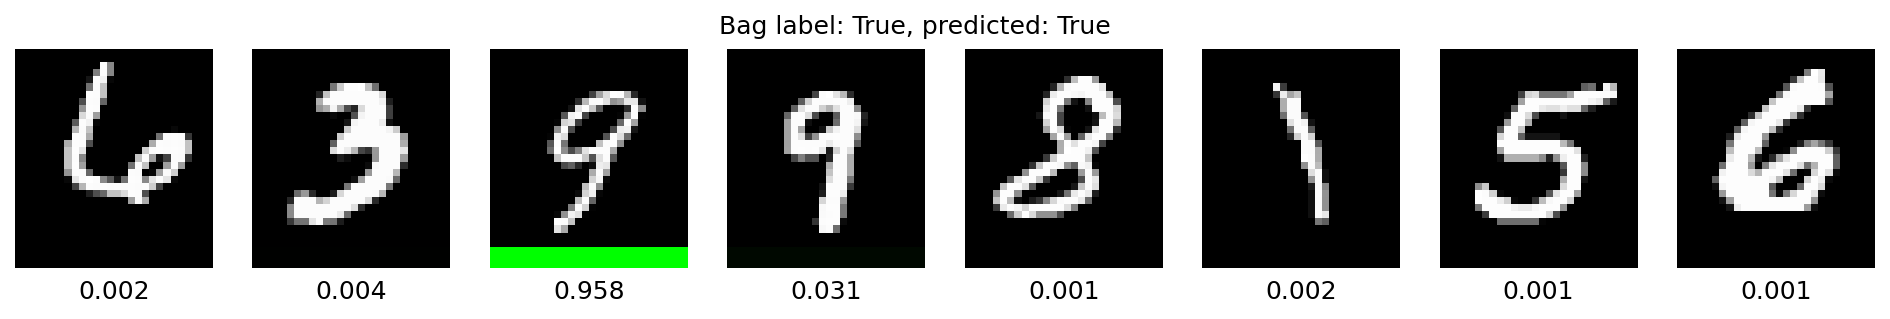

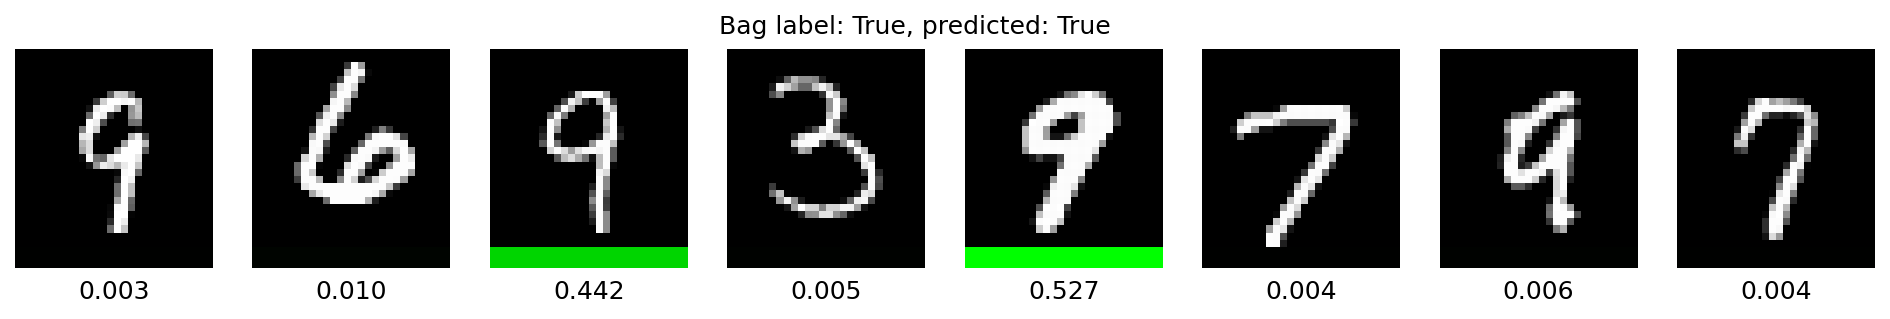

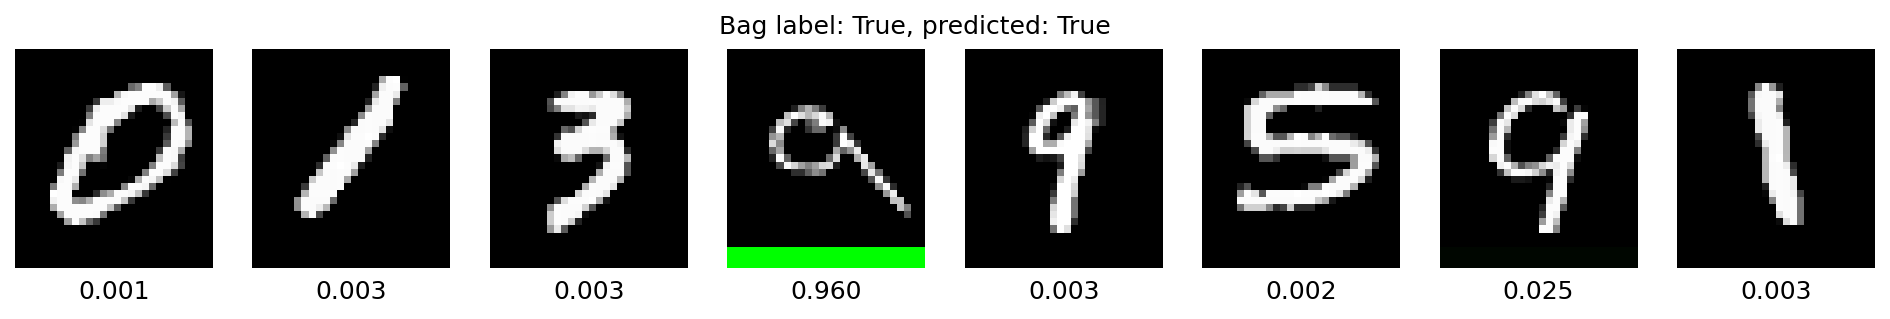

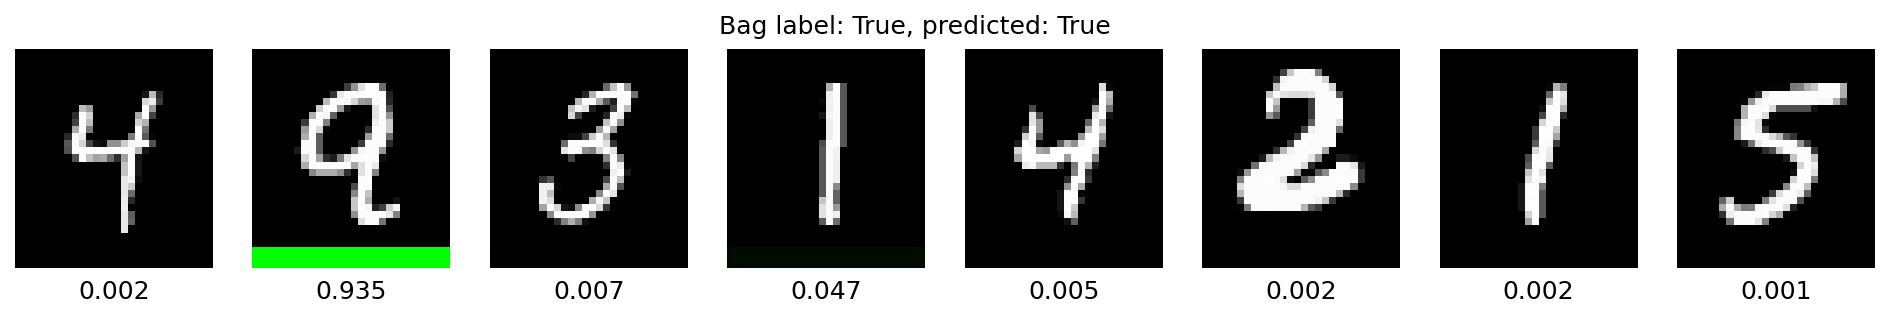

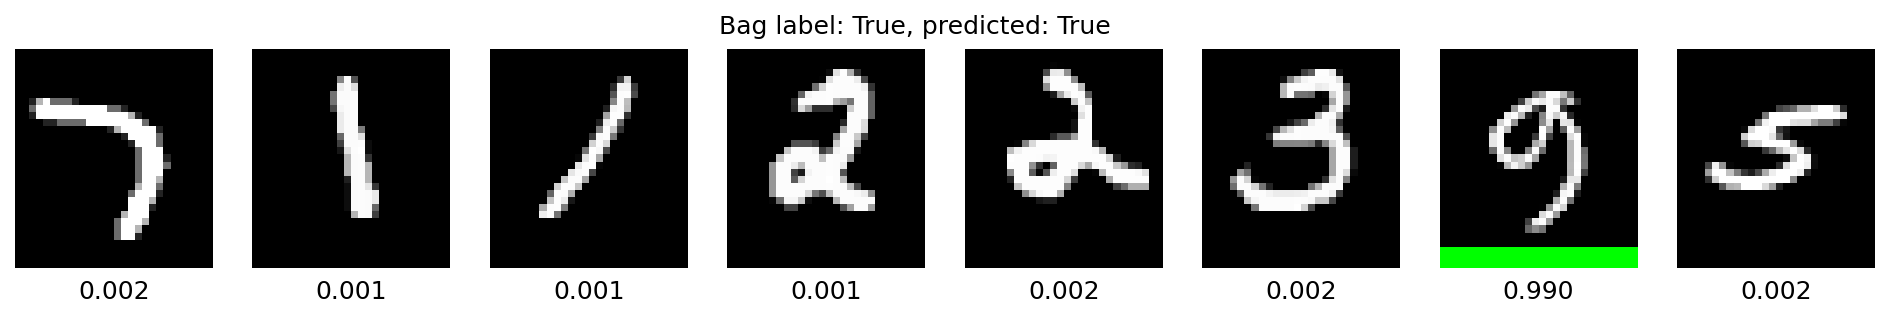

In [534]:
make_test_plots(n_images=5, only='true_positive',
                save_dir=(base_plots_path / 'attention_weights_TP'))


Test Set, Loss: 0.0009, Test error: 0.0000


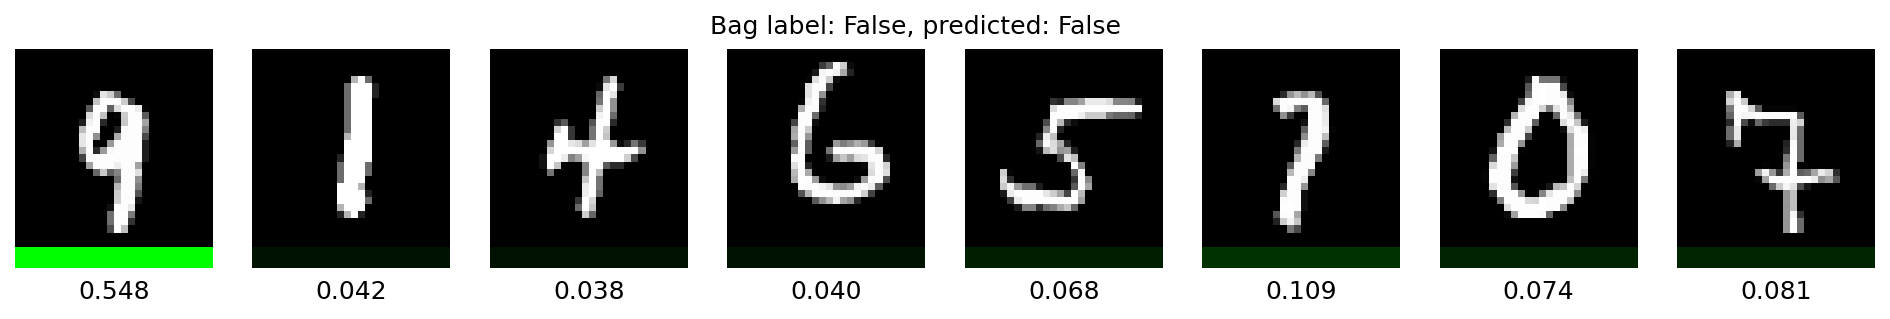

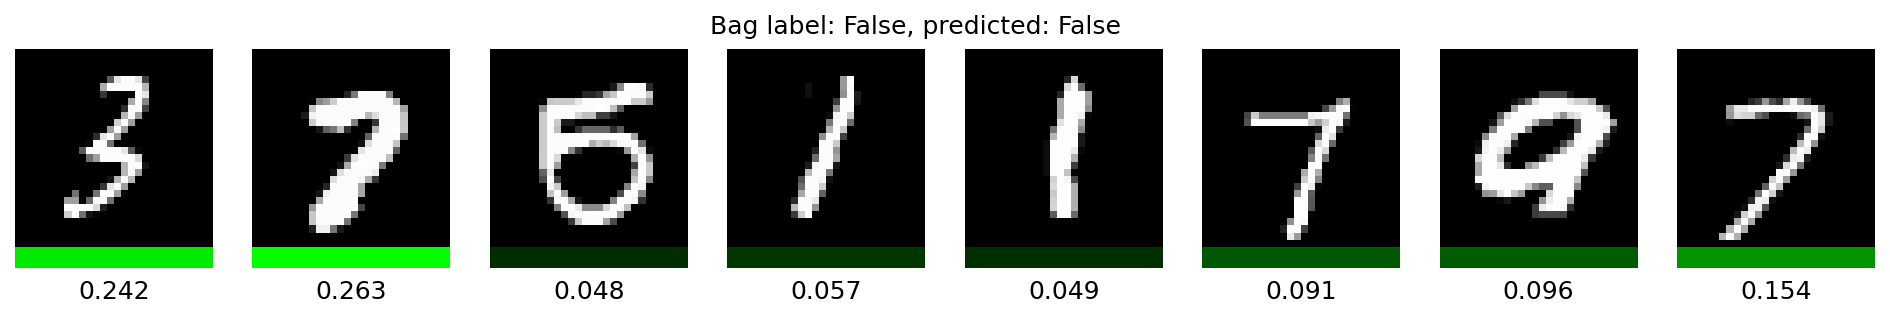

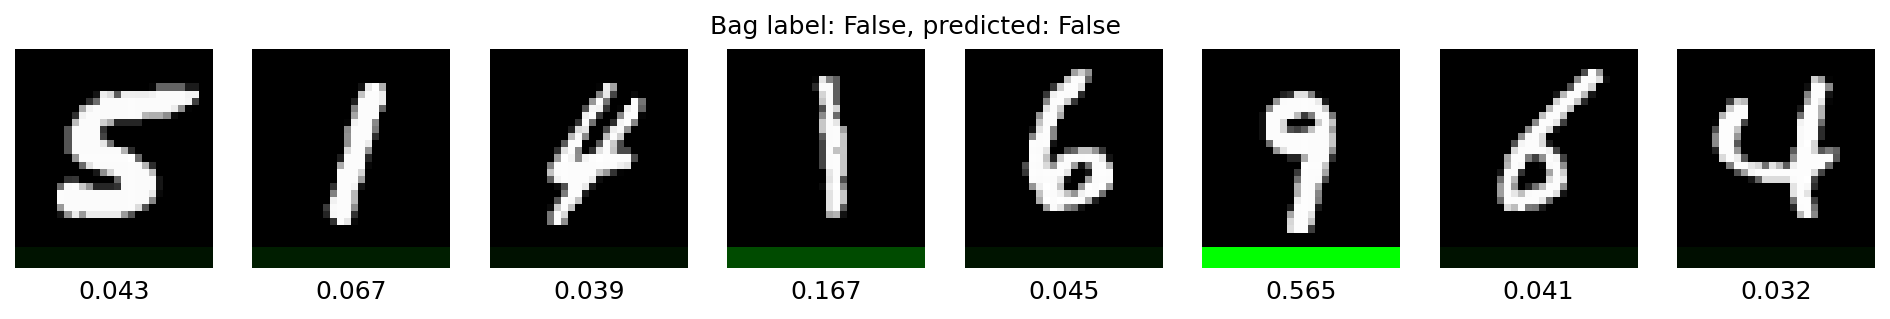

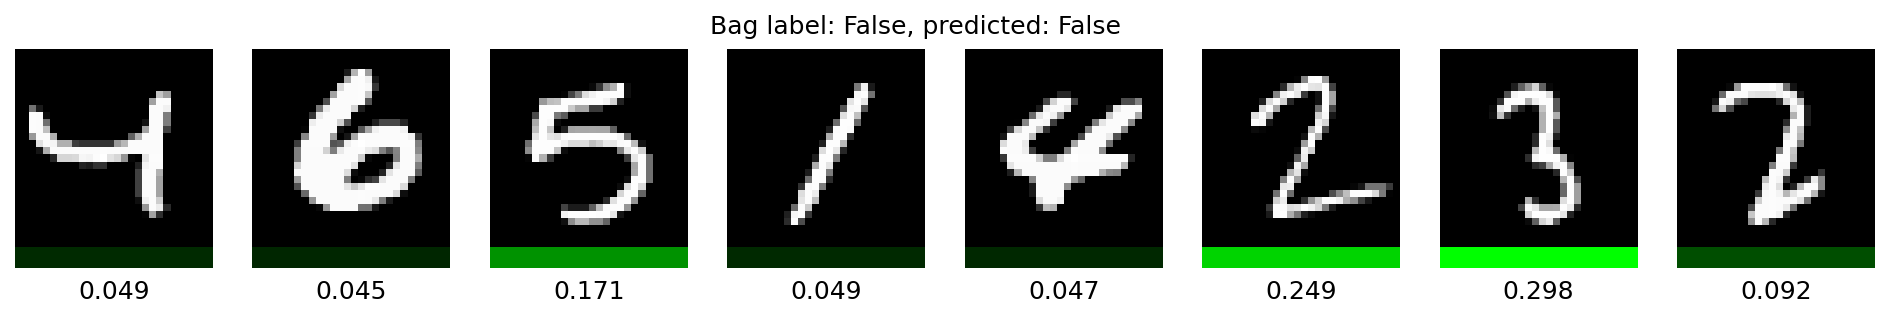

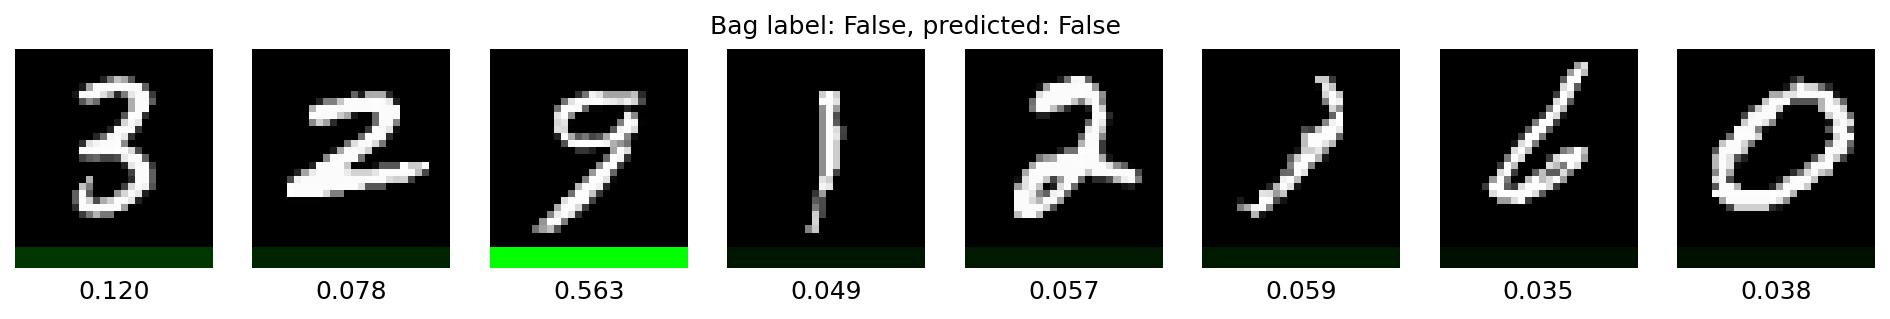

In [535]:
make_test_plots(n_images=5, only='true_negative',
                save_dir=(base_plots_path / 'attention_weights_TN'))


Test Set, Loss: 0.0714, Test error: 0.0130


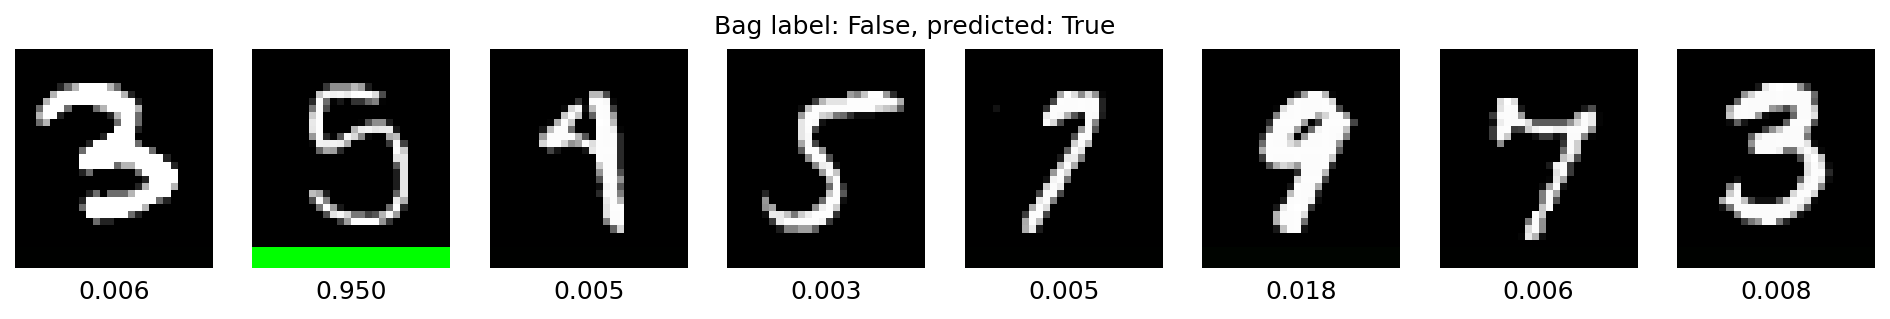

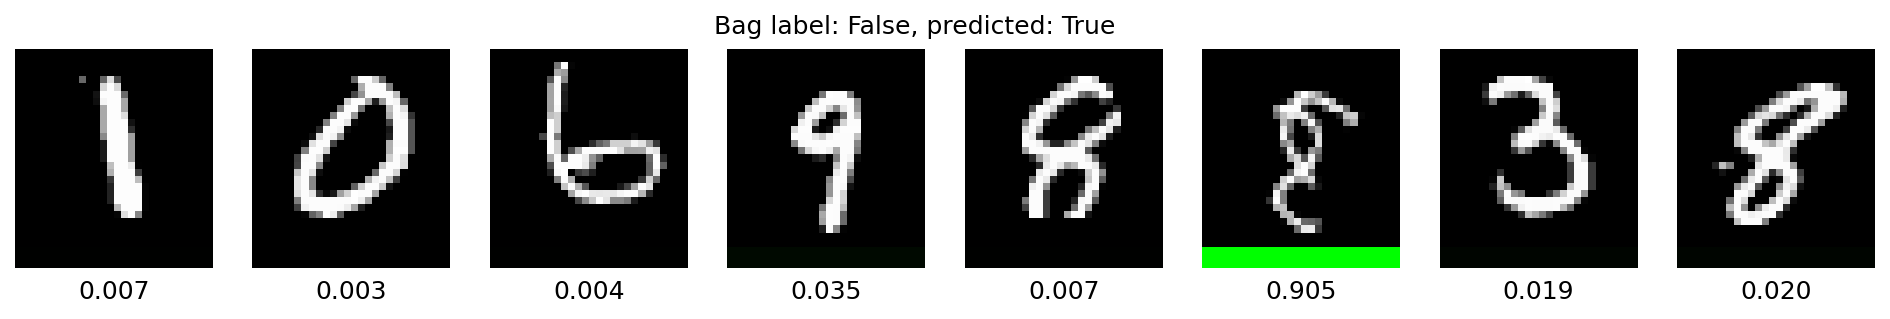

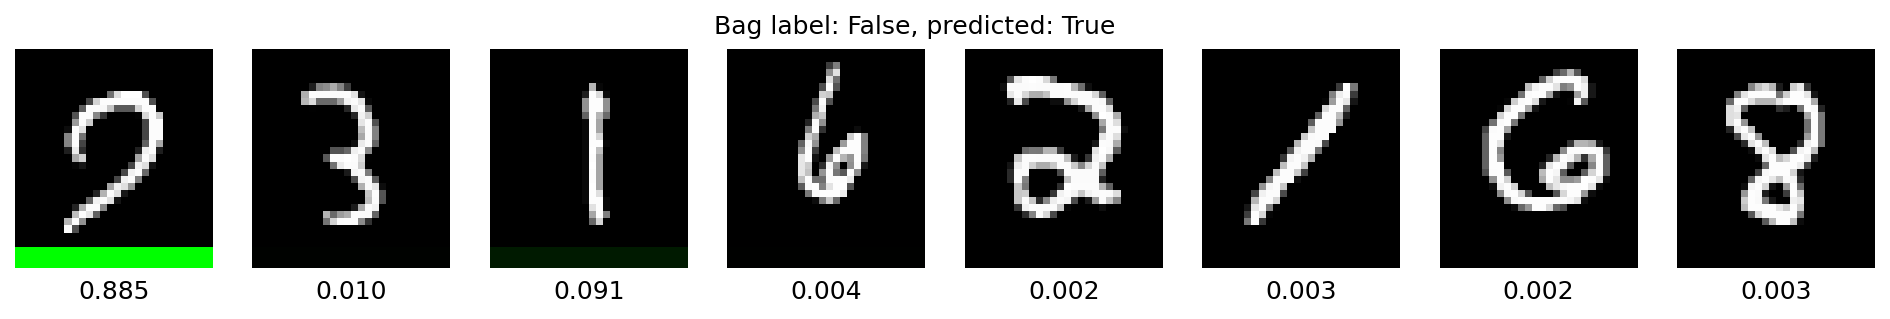

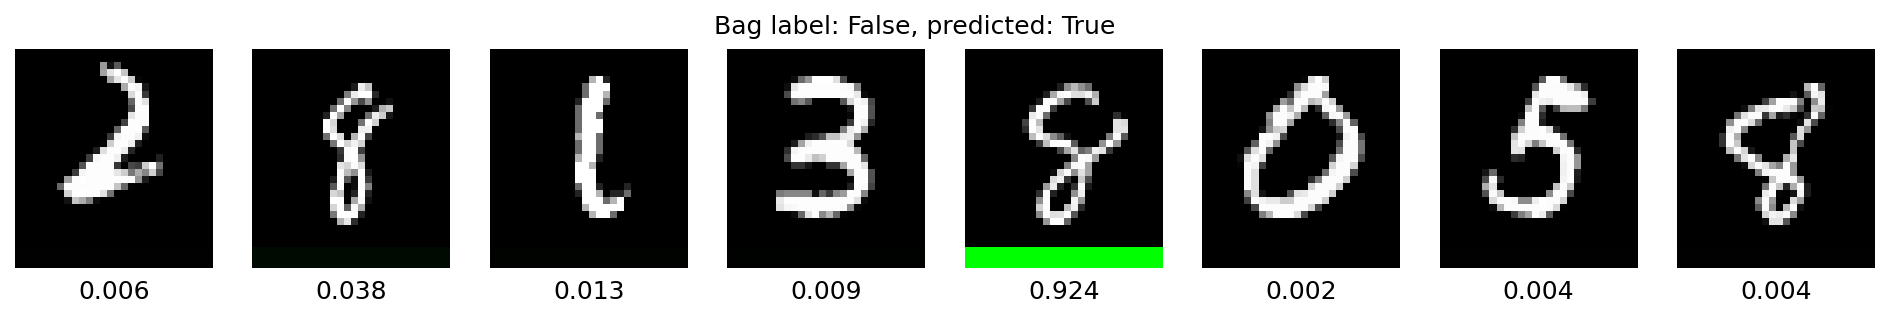

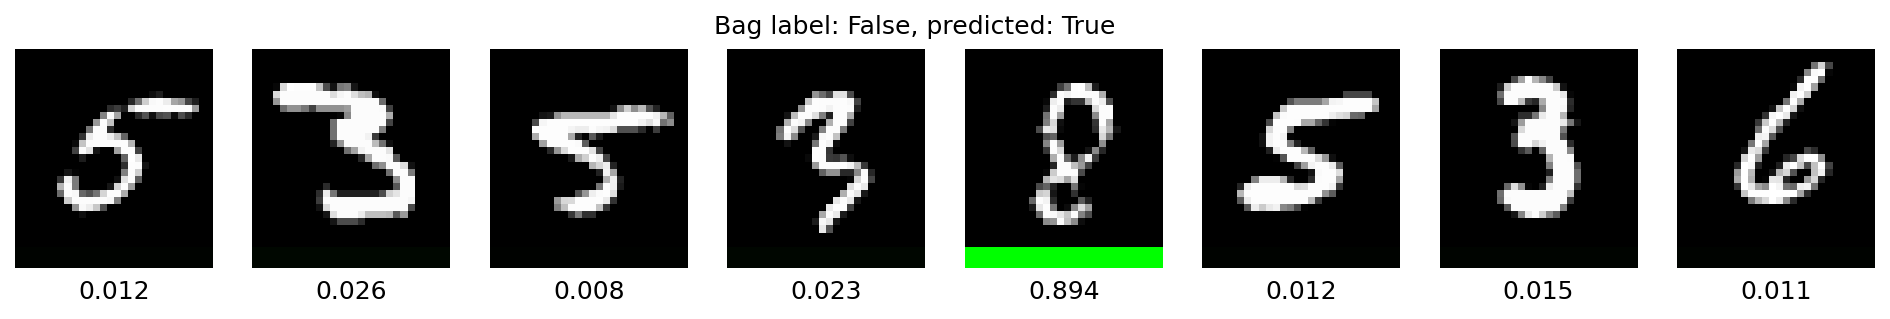

In [536]:
make_test_plots(n_images=5, num_bags=2000, only='false_positive',
                save_dir=(base_plots_path / 'attention_weights_FP'))


Test Set, Loss: 0.0714, Test error: 0.0130


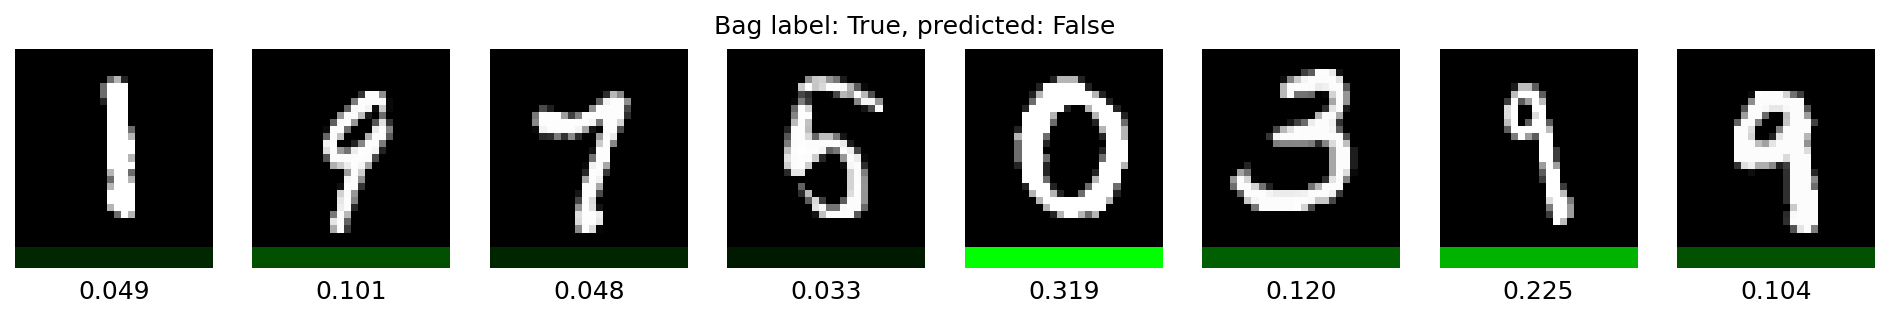

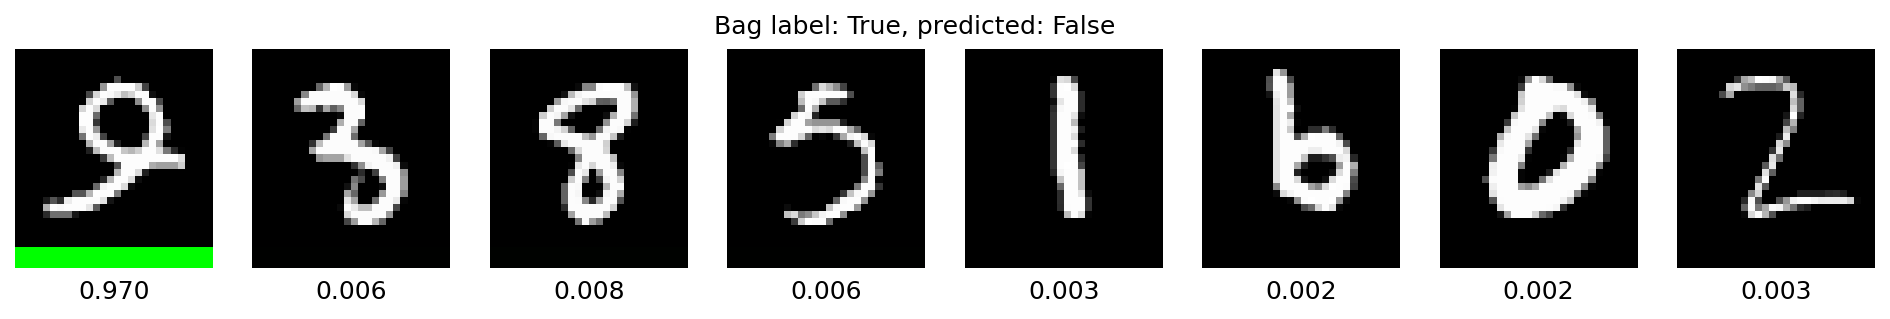

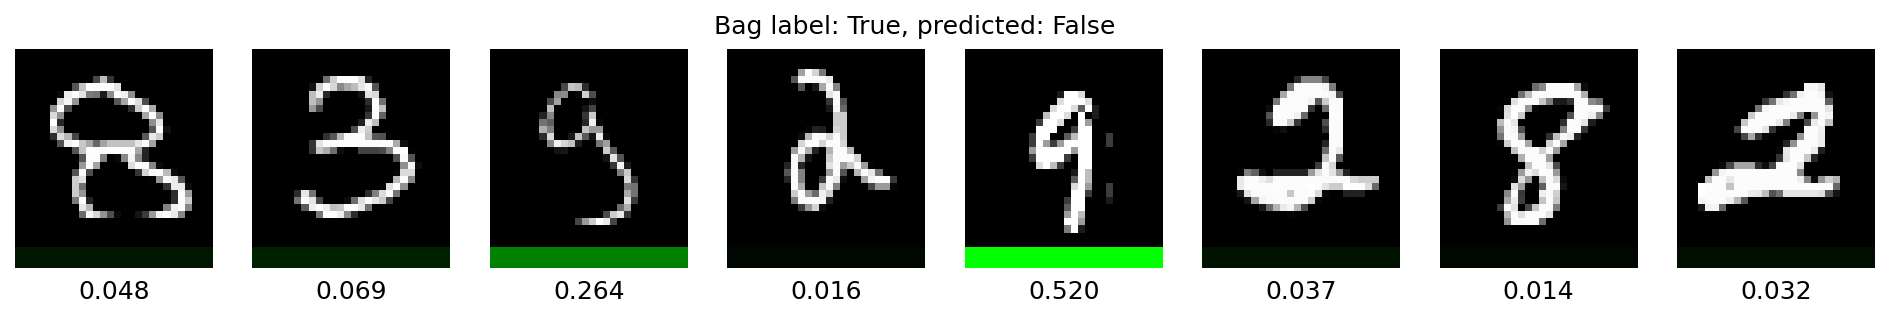

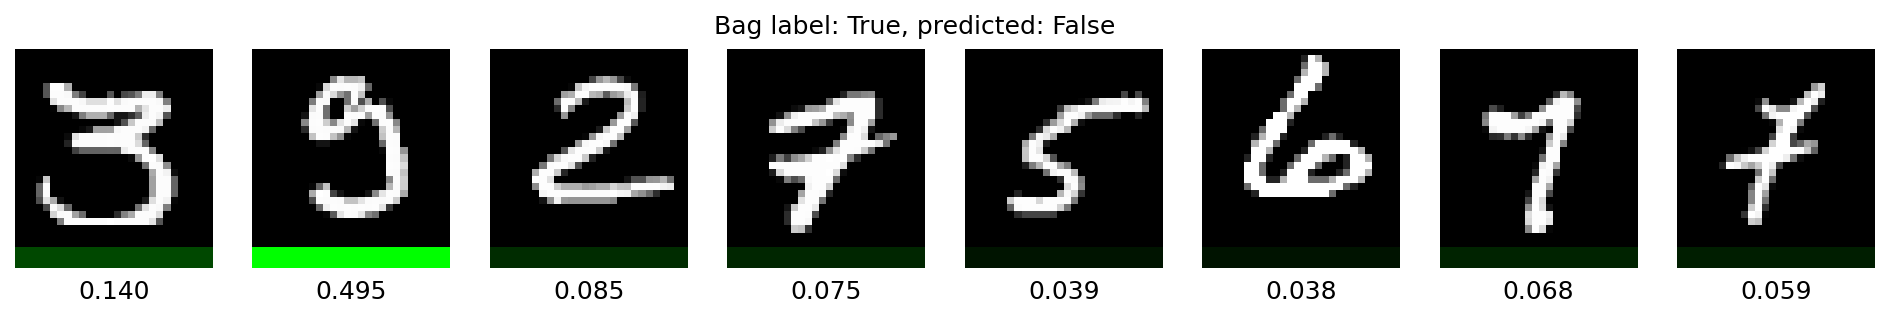

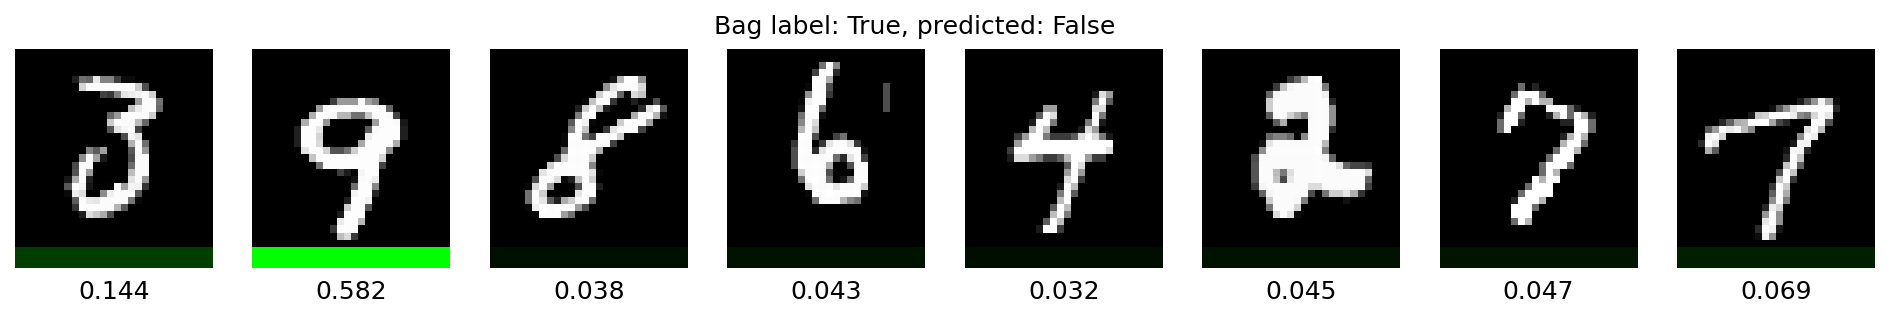

In [537]:
make_test_plots(n_images=5, num_bags=2000, only='false_negative',
                save_dir=(base_plots_path / 'attention_weights_FN'))